# Table of Contents
 <p><div class="lev1"><a href="#Data-Dashboard-library/plugin"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Dashboard library/plugin</a></div><div class="lev2"><a href="#Propose"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Propose</a></div><div class="lev3"><a href="#Data-information"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Data information</a></div><div class="lev3"><a href="#Data-cleaning"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev3"><a href="#Data-visualization"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Data visualization</a></div>

# Data Dashboard library/plugin

## Propose

The propose of this library/plugin is to allow the data analysis process more 
easy and automatic.

The library will join some methods to help the data manipulation, data cleaning 
and data visualization.

### Data information

When a dataframe were selected, the library will show some information about the
dataframe, such as:

* total of attributes;
* total of instances;
* type of each attributes;
* total of NaN values for each attribute;

### Data cleaning


### Data visualization


In [1]:
from IPython.display import display, HTML
from ipywidgets import widgets
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import textwrap
import traceback

%matplotlib notebook

In [2]:
def str2enum(data: pd.DataFrame) -> (pd.DataFrame, dict):
    enums = {}
    data = data.copy()
    for k in data.keys():
        if data[k].dtype == object:
            enums[k] = []
            for i, v in enumerate(set(data[k])):
                enums[k].append(v)
                data[k].replace(v, i, inplace=True)
    return data, enums

In [3]:
data = pd.read_csv('data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
widgets.HTML

ipywidgets.widgets.widget_string.HTML

In [5]:
# df, emums = str2enum(data)
df = data.copy()
df.loc[df.Survived==0, 'Survived'] = 'Died'
df.loc[df.Survived==1, 'Survived'] = 'Survived'
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,Died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,Survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,Survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,Survived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,Died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# numerical type
ref_options = 'Age'
field = 'Survived'

_data = data.copy().dropna()
labels = list(set(_data.Survived))
#new = df.apply(lambda x: pd.Series(pd.cut(x*100,bins)))
for l in labels:
    _data[l] = (_data[field] == l).replace(False, np.nan)
    
_data = _data[[ref_options]+labels]
"""
_data_g = _data.hist(by='Age')


print(labels)
display(_data_g.head())
"""
_data.Age, _ = pd.cut(_data.Age, bins=5, retbins=True)

print(list(set(_data.Age)))

_data_g = _data.groupby(by=[ref_options]).count()

['(16.736, 32.552]', '(32.552, 48.368]', '(48.368, 64.184]', '(0.841, 16.736]', '(64.184, 80]']


<IPython.core.display.Javascript object>


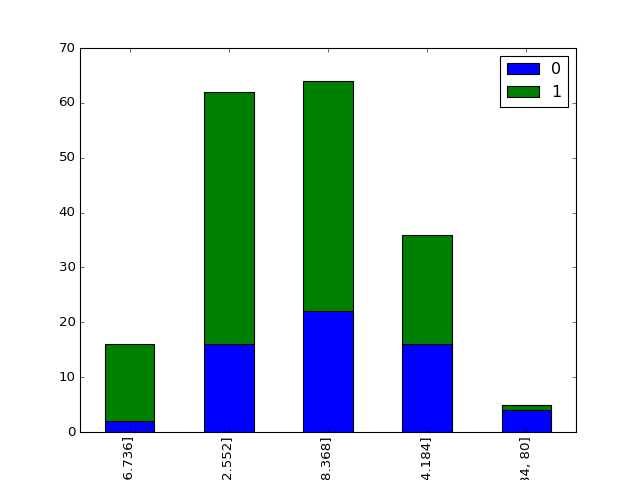

In [7]:
f, ax = plt.subplots()
_data_g.plot.bar(ax=ax, stacked=True)
plt.legend()
#plt.tight_layout()
plt.show()

In [8]:
def chart_observe_callback(data):
    def callback(change=None):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()
        
        """
        fields = list(select_list_fields.selected_labels)
        ref = dropdown_field_ref.selected_label
        ax.cla()
        
        message_box.margin = 0
        message_box.value = ''
        
        try:
            if fields:
                if 'i' in df.Pclass.dtype.str or 'f' in df.Pclass.dtype.str:
                    # nominal type
                    _data = data.copy()
                    ref_options = list(set(_data[ref]))
                    for o in ref_options:
                        _data[o] = (_data[ref]==o).replace(False, np.nan)

                    _data.groupby(by=fields)[ref_options].count().plot(
                        ax=ax, kind='bar', stacked=True
                    )
                else:
                    # numerical type
                    _data = data.copy()
                    _data.groupby(by=fields)[ref_options].hist(
                        ax=ax, stacked=True
                    )

            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()

            plt.draw()
        except:
            t = '<br/>'.join(textwrap.wrap(traceback.format_exc(), 80))
            message_box.value = t
            message_box.margin = 30
    return callback


def data_observe_callback(data):
    def callback(btn):
        """
        Ex:
        k = ['Sex', 'Survived']
        df[k].groupby(by='Sex').sum()
        
        """
        fields = list(select_list_fields.selected_labels)
        ref = dropdown_field_ref.selected_label
        table_box.value = ''
        
        if btn.description == 'hidden data':
            btn.description = 'show data'
            return
        
        btn.description = 'hidden data'
        
        if fields:
            fields = [ref]+fields
            table_box.value = data.groupby(by=fields)[fields].count().to_html()
        
    return callback

<IPython.core.display.Javascript object>


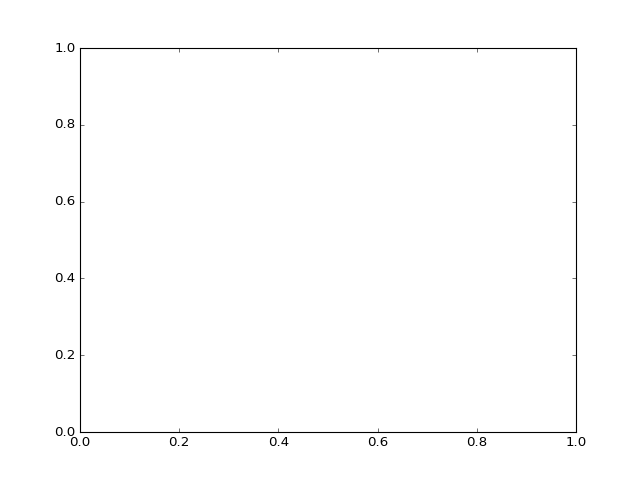

In [9]:
message_box = widgets.HTML()
table_box = widgets.HTML()

select_list_fields = widgets.SelectMultiple(
    description='Select the fields of aggregation:',
    options=[i for i in data.keys()]
)

dropdown_field_ref = widgets.Dropdown(
    description='Select the field of reference:',
    options=[i for i in data.keys()]
)

dropdown_field_ref.padding = 2
select_list_fields.padding = 2

select_list_fields.observe(chart_observe_callback(df))
dropdown_field_ref.observe(chart_observe_callback(df))


# graphic
ax = plt.figure().gca()
    
# button
btn_show_data = widgets.Button(description="show data")
btn_show_data.on_click(data_observe_callback(df))
plt.show()

display(message_box)
display(dropdown_field_ref)
display(select_list_fields)
display(btn_show_data)
display(table_box)
#chart_observe_callback(df)()